# **Data Cleaning**

## Objectives

* Download data from Kaggle.com and perform an initial EDA.

## Inputs

* unclean_smartwatch_health_data.csv

## Outputs

* ydata-profiling EDA

## Additional Comments

* In case you have any additional comments that don't fit in the previous bullets, please state them here. 


---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspaces/Project_5_Predictive_Analytics/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspaces/Project_5_Predictive_Analytics'

Include our data path

In [7]:
DataUntouched = "inputs/smartwatch_health_data_untouched"

In [8]:
import pandas as pd
data = pd.read_csv(DataUntouched + "/unclean_smartwatch_health_data.csv")
df = pd.DataFrame(data)
print(df.head())

# Change version variable to store outputs in different folder
version = "v1"

OutputFolder = f"outputs/{version}/"
if "outputs" in os.listdir(current_dir):
    if version not in os.listdir(current_dir + "/outputs"):
        os.mkdir(OutputFolder)
else:
    os.makedirs(OutputFolder)

   User ID  Heart Rate (BPM)  Blood Oxygen Level (%)    Step Count  \
0   4174.0         58.939776               98.809650   5450.390578   
1      NaN               NaN               98.532195    727.601610   
2   1860.0        247.803052               97.052954   2826.521994   
3   2294.0         40.000000               96.894213  13797.338044   
4   2130.0         61.950165               98.583797  15679.067648   

  Sleep Duration (hours) Activity Level Stress Level  
0      7.167235622316564  Highly Active            1  
1      6.538239375570314  Highly_Active            5  
2                  ERROR  Highly Active            5  
3      7.367789630207228          Actve            3  
4                    NaN  Highly_Active            6  


# Clean data

Cleaning will be performed, as from the initial EDA we can see we have 1551 missing cells across all features, Hypothesis 1 doesnt have a target variable as we are looking to perform unsupervised clustering to group. Hypothesis 2's target is Stress Levels and hypothesis 3's is Step Count.

Now we will drop the User ID feature and perform imputation of numeric and categoric variables.
Also try and imporove normality and skewness on the columns that require it.

---

Drop User ID from a copy of the original

In [9]:
df_todrop = df.copy()
df_dropped = df_todrop.drop("User ID", axis=1)

In [ ]:
print(df_dropped.columns)
df_dropped.head()

Data types of columns:
Heart Rate (BPM): float64
Blood Oxygen Level (%): float64
Step Count: float64
Sleep Duration (hours): object
Activity Level: object
Stress Level: object
Index(['Heart Rate (BPM)', 'Blood Oxygen Level (%)', 'Step Count',
       'Sleep Duration (hours)', 'Activity Level', 'Stress Level'],
      dtype='object')


,Heart Rate (BPM),Blood Oxygen Level (%),Step Count,Sleep Duration (hours),Activity Level,Stress Level
0,58.939776,98.809650,5450.390578,7.167235622316564,Highly Active,1
1,NaN,98.532195,727.601610,6.538239375570314,Highly_Active,5
2,247.803052,97.052954,2826.521994,ERROR,Highly Active,5
3,40.000000,96.894213,13797.338044,7.367789630207228,Actve,3
4,61.950165,98.583797,15679.067648,NaN,Highly_Active,6


Before imputing im going to try improving the normal distribution of the variables, as this decides wether you use the median or the mean for imputation of numerics

   Heart Rate (BPM)  Blood Oxygen Level (%)  Step Count
0          2.564209            8.852688e+31   34.808695
1          2.650256            8.448312e+31   18.517698
2          3.003424            6.569606e+31   28.484598
3          2.416272            6.393207e+31   45.934882
4          2.582208            8.522180e+31   47.699914
*** Heart Rate (BPM) ***


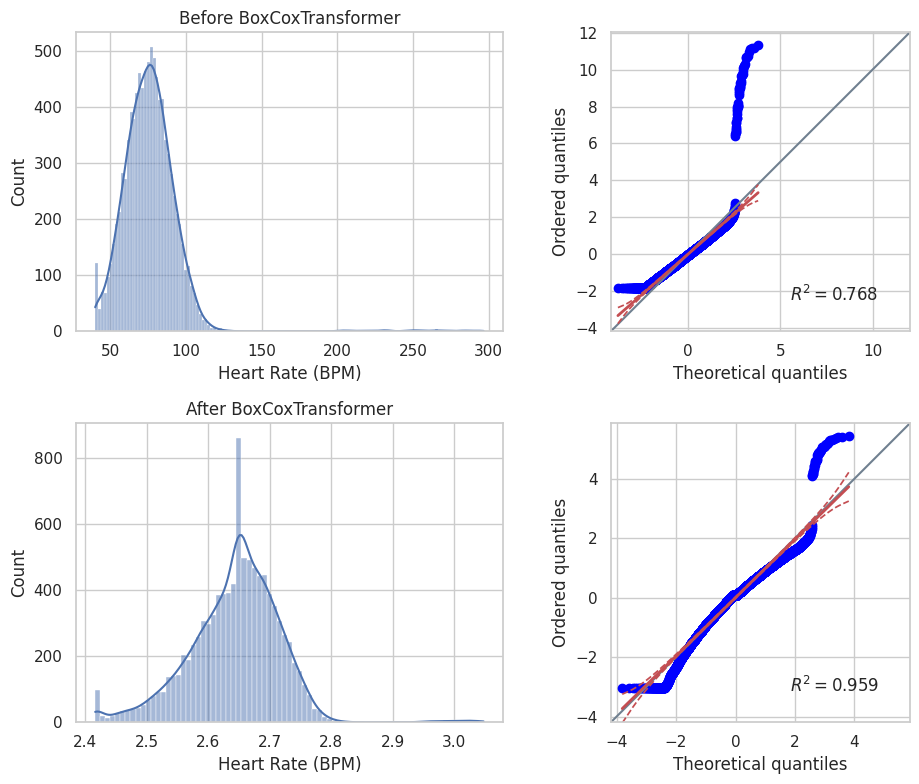

before transformation  | skewness: 3.89 | kurtosis: 35.57
after transformation  | skewness: -0.05 | kurtosis: 2.65


*** Blood Oxygen Level (%) ***


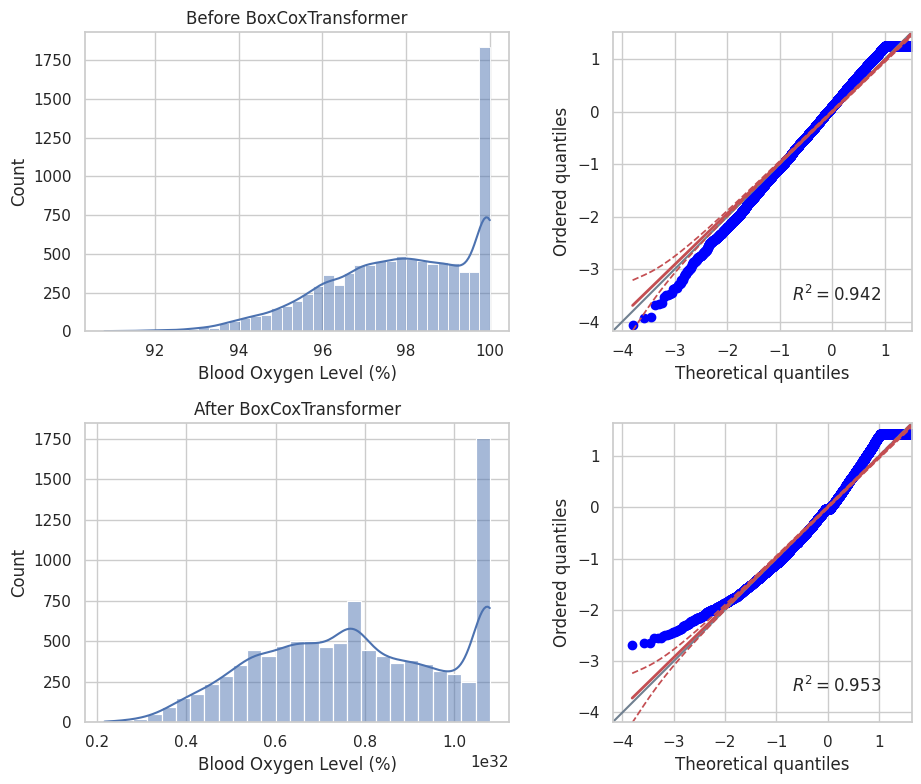

before transformation  | skewness: -0.57 | kurtosis: -0.31
after transformation  | skewness: -0.1 | kurtosis: -1.0


*** Step Count ***


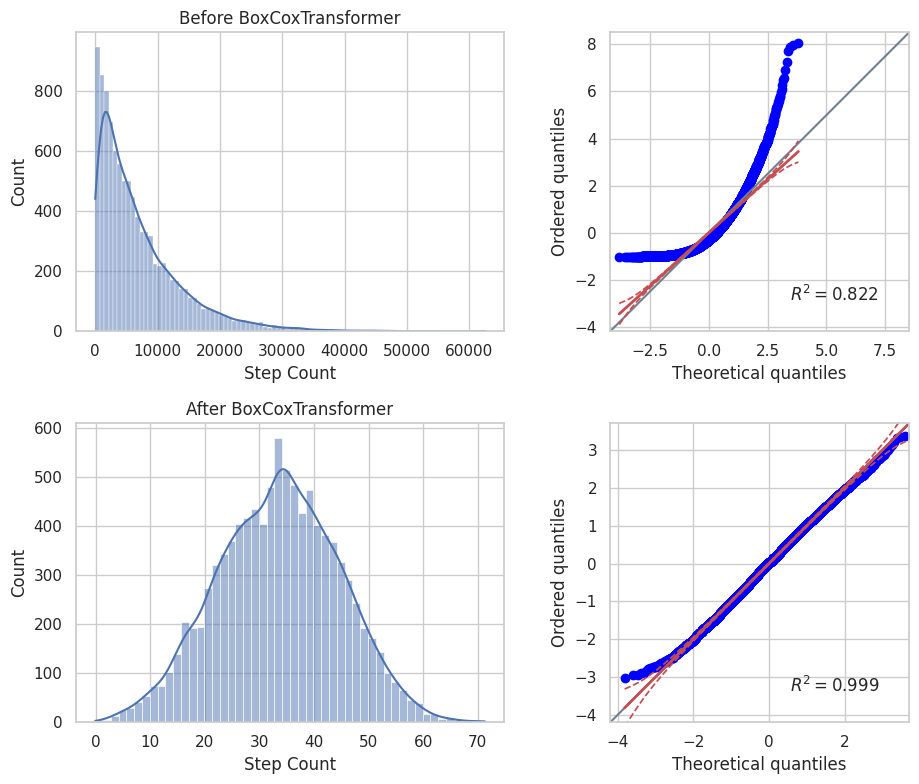

before transformation  | skewness: 1.97 | kurtosis: 5.96
after transformation  | skewness: -0.04 | kurtosis: -0.26




In [16]:
from sklearn.pipeline import Pipeline
from feature_engine import transformation as vt
from feature_engine.imputation import MeanMedianImputer
import seaborn as sns
import pingouin as pg
import matplotlib.pyplot as plt

df_numeric = df_dropped.select_dtypes(include=['float64','int64'])
df_numeric.head()

def calculate_skew_kurtosis(df,col, moment):
  print(f"{moment}  | skewness: {df[col].skew().round(2)} | kurtosis: {df[col].kurtosis().round(2)}")


# We set the pipeline with this transformer: vt.BoxCoxTransformer().
# Then we .fit_transform() the pipeline, assigning the result to df_transformed

pipeline = Pipeline([
      ('median',  MeanMedianImputer(imputation_method='median') ),
      ( 'log', vt.BoxCoxTransformer() ) # Main difference here
  ])

df_transformed = pipeline.fit_transform(df_numeric)
print(df_transformed.head())

def compare_distributions_before_and_after_applying_transformer(df, df_transformed, method):

  for col in df.columns:
    print(f"*** {col} ***")
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10,8))

    sns.histplot(data=df, x=col, kde=True, ax=axes[0,0])
    axes[0,0].set_title(f'Before {method}')
    pg.qqplot(df[col], dist='norm',ax=axes[0,1])
    
    sns.histplot(data=df_transformed, x=col, kde=True, ax=axes[1,0])
    axes[1,0].set_title(f'After {method}')
    pg.qqplot(df_transformed[col], dist='norm',ax=axes[1,1])
    
    plt.tight_layout()
    plt.show()

    calculate_skew_kurtosis(df,col, moment='before transformation')
    calculate_skew_kurtosis(df_transformed,col, moment='after transformation')
    print("\n")
    
compare_distributions_before_and_after_applying_transformer(df_numeric, df_transformed, method='BoxCoxTransformer')


In [ ]:
# Change datatypes of these columns after datasets missing values are imputed
df["Sleep Duration (hours)"].astype("float64")
df["Stress Level"].astype("int64")

# Check the data types of the columns again
print("Data types of columns:")
for column, dtype in df.dtypes.items():
    print(f"{column}: {dtype}")


# Section 2 EDA

Section 2 content

---

NOTE

* You may add as many sections as you want, as long as it supports your project workflow.
* All notebook's cells should be run top-down (you can't create a dynamic wherein a given point you need to go back to a previous cell to execute some task, like go back to a previous cell and refresh a variable content)

---

# Push files to Repo

* In case you don't need to push files to Repo, you may replace this section with "Conclusions and Next Steps" and state your conclusions and next steps.

In [ ]:
import os
try:
  # create here your folder
  # os.makedirs(name='')
except Exception as e:
  print(e)
